## Importations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import ADASYN

from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing

from sklearn.impute import SimpleImputer

from xgboost import DMatrix, train

In [2]:
# # Define a custom formatter to remove negative sign from zeros
# def custom_formatter(x):
#     return f"{x:.4f}".replace('-0.0000', '0.0000')

# # Set pandas display option to use the custom formatter
# pd.set_option('display.float_format', custom_formatter)
# pd.set_option('display.float_format', '{:.4f}'.format)

## Data Loading

The original MaFaulDa was sampled using 50 kHz 24-bit 8-channel, but this work will use audio data only, which is the 8th channel only. This work uses 24 kHz 16-bit PCM 1-channel (mono) with a normalization of -6 dBFS. So the dataset was completely converted to the mentioned specifications using SoX.

The segmentation used segment duration of 500 ms and overlap duration of 20 ms. Then, the featured extraction produced a CSV file with several columns of features, a column of class label, a column of class number, and a column of filename.

The following cell imports the data from the CSV, shows its general information, shows a few of its samples, and shows the amount of samples per class.

In [3]:
# loading data
DIR = "data"
CSV_FILE = "new_mafaulda_24khz_500ms_20ms_40-mfcc.csv"
df = pd.read_csv(DIR + "/" + CSV_FILE)

# adding source column to the dataframe
df["source"] = "original"

# show dataframe info
df.info()

# print number of samples per class
df["label"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19510 entries, 0 to 19509
Columns: 147 entries, mean to source
dtypes: float64(143), int64(1), object(3)
memory usage: 21.9+ MB


underhang                  5580
overhang                   5130
imbalance                  3330
vertical_misalignment      3010
horizontal_misalignment    1970
normal                      490
Name: label, dtype: int64

In [4]:
# show dataframe head
df.head()

,mean,median,variance,standard_deviation,skewness,kurtosis,energy,power,min,max,...,delta_delta_mfcc_35,delta_delta_mfcc_36,delta_delta_mfcc_37,delta_delta_mfcc_38,delta_delta_mfcc_39,delta_delta_mfcc_40,filename,class,label,source
0,0.011783,0.007889,0.002218,0.047093,0.861221,1.019698,28.279595,0.002357,-0.094940,0.202728,...,0.04945,-0.103265,0.206889,-0.002884,-0.011142,0.096565,normal/47.7184.wav,0,normal,original
1,0.011942,0.007980,0.002252,0.047456,0.849527,0.966163,28.736179,0.002395,-0.090546,0.206665,...,0.04945,-0.103265,0.206889,-0.002884,-0.011142,0.096565,normal/47.7184.wav,0,normal,original
2,0.011660,0.007996,0.002227,0.047186,0.838631,0.991242,28.350076,0.002363,-0.095276,0.215637,...,0.04945,-0.103265,0.206889,-0.002884,-0.011142,0.096565,normal/47.7184.wav,0,normal,original
3,0.011467,0.007339,0.002225,0.047173,0.854475,1.014259,28.281024,0.002357,-0.091705,0.204559,...,0.04945,-0.103265,0.206889,-0.002884,-0.011142,0.096565,normal/47.7184.wav,0,normal,original
4,0.011612,0.007568,0.002209,0.047005,0.834740,0.967761,28.131957,0.002344,-0.091614,0.203339,...,0.04945,-0.103265,0.206889,-0.002884,-0.011142,0.096565,normal/47.7184.wav,0,normal,original


Now, let's check if there are any NaN values, and, if necessary, we'll remove the columns (features) with at least one NaN value.

In [5]:
# count the number of NaN values in each column
total_nan = df.isna().sum().sum()

# count the number of rows with at least one NaN value
rows_nan = df.isna().any(axis=1).sum()

# count the number of columns with at least one NaN value
columns_nan = df.isna().any().sum()

# create a copy of dataframe without columns with at least NaN
df_without_nan = df.dropna(axis=1)

print("NaN values in DataFrame:", total_nan)
print("Rows with at least one NaN value:", rows_nan)
print("Columns with at least one NaN value:", columns_nan)

NaN values in DataFrame: 0
Rows with at least one NaN value: 0
Columns with at least one NaN value: 0


Now, we get separate variables for features and classes. Also, we create a label encoder for preprocessing and use it to get classes numbers. Then, we get features (X) and class numbers (y) arrays.

In [6]:
# extract the features and the class
features = df_without_nan.drop(columns=["filename", "label", "class", "source"])
class_column = df_without_nan["class"]

# encode class column if necessary
label_encoder = preprocessing.LabelEncoder()
class_column_encoded = label_encoder.fit_transform(class_column)

# set X and y values
X = features.values
y = class_column_encoded.copy()

Standardize data for both train and test steps.

In [8]:
scaler = preprocessing.RobustScaler()
# scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.MaxAbsScaler()
# scaler = preprocessing.Normalizer(norm='l1')
# scaler = preprocessing.Normalizer(norm='l2')
# scaler = preprocessing.Normalizer(norm='max')
# scaler = preprocessing.PowerTransformer(method="yeo-johnson")
# scaler = preprocessing.QuantileTransformer(output_distribution="uniform", random_state=42)
# scaler = preprocessing.QuantileTransformer(output_distribution="normal", random_state=42)

X = scaler.fit_transform(X)

Now, we apply a data augmentation to the dataset of features and classes.

We also add the "source" column, because it is used to be sure that there are no samples from the same file used both in training and testing steps.

Then, we check the amount of samples per class generated by the data augmentation process.

In [9]:
# apply ADASYN (oversampling minority class) to the dataset
sampling_strategy = {
    0: 6000,
    1: 6000,
    2: 6000,
    3: 6000,
    4: 6000,
    5: 6000}
# sampling_strategy = "minority"
X_resampled, y_resampled = ADASYN(sampling_strategy=sampling_strategy, random_state=42).fit_resample(X, y)

n_generated = X_resampled.shape[0] - X.shape[0]

# create a new dataframe with the new samples
new_df = pd.DataFrame(X_resampled[-n_generated:], columns=features.columns)
new_df["class"] = label_encoder.inverse_transform(y_resampled[-n_generated:])
new_df["source"] = "generated"

# add label column to the dataframe of new samples
new_df.loc[new_df["class"] == 0, "label"] = "normal"
new_df.loc[new_df["class"] == 1, "label"] = "horizontal_misalignment"
new_df.loc[new_df["class"] == 2, "label"] = "vertical_misalignment"
new_df.loc[new_df["class"] == 3, "label"] = "imbalance"
new_df.loc[new_df["class"] == 4, "label"] = "overhang"
new_df.loc[new_df["class"] == 5, "label"] = "underhang"

# add filename column to the new dataframe
original_filenames = df["filename"].values
new_filenames = [f"generated_{i}.wav" for i in range(len(original_filenames), len(original_filenames) + len(new_df))]
new_df["filename"] = new_filenames

# print the amount of new samples generated per class
new_df["label"].value_counts()

normal                     5510
horizontal_misalignment    4021
vertical_misalignment      2991
imbalance                  2642
overhang                    876
underhang                   395
Name: label, dtype: int64

Concatenate both original dataframe and new dataframe created with generated samples to create an augmented dataframe.

In [10]:
# # concatenate the original dataframe with the new dataframe
df_resampled = pd.concat([df, new_df], ignore_index=True)
# df_resampled = new_df

# show dataframe info
df_resampled.info()

# print number of samples per class
df_resampled["label"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35945 entries, 0 to 35944
Columns: 147 entries, mean to source
dtypes: float64(143), int64(1), object(3)
memory usage: 40.3+ MB


overhang                   6006
vertical_misalignment      6001
normal                     6000
horizontal_misalignment    5991
underhang                  5975
imbalance                  5972
Name: label, dtype: int64

In [11]:
df_resampled["source"].value_counts()

original     19510
generated    16435
Name: source, dtype: int64

In [12]:
# df_resampled.hist(bins=30, figsize=(20, 15))
# plt.show()

Saves the list of features in the dataframe and the labels to be used later.

In [13]:
FEATURES_LST    = [column for column in df_resampled.columns if column not in ["filename", "class", "label", "source"]]
labels          = list(df_resampled["label"].unique())

Splitting the data into train and test sets using unique files only, which means that there will be no samples in both train and test sets that came from the same file. For example, let us say that the file "audio.wav" produced 10 segments. Each segment was used to extract features, so there will be 10 entries at the dataframe that came from the very same audio file. Considering that those 10 entries came from the same file, we can say that, necessarily, all 10 samples came from the very same class and, more than that, they come from the very same scenario. So, if some of the 10 entries were used to train and the others were used to test, it would be considered some kind of cheating. Then, it would be recommended to used all those entries in one set only, that could be all of them used to train or all of them used to test. So, this is the reason why we have to use the "unique" function to the "filename" column of "df_resampled" dataframe.

In [14]:
# splitting the data into training and test sets
TEST_SIZE       = 0.20
RANDOM_STATE    = 42

# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

unique_files = df_resampled["filename"].unique()

train_files, test_files = model_selection.train_test_split(unique_files, test_size=TEST_SIZE, random_state=RANDOM_STATE)

train_df    = df_resampled[df_resampled['filename'].isin(train_files)]
test_df     = df_resampled[df_resampled['filename'].isin(test_files)]

print(f"Train files:    {len(train_files)}  ({len(train_df) / len(df_resampled) * 100:.2f}%)")
print(f"Test files:     {len(test_files)}   ({len(test_df) / len(df_resampled) * 100:.2f}%)")
print(f"Train samples:  {len(train_df)}     ({len(train_df) / len(df_resampled) * 100:.2f}%)")
print(f"Test samples:   {len(test_df)}      ({len(test_df) / len(df_resampled) * 100:.2f}%)")

Train files:    14708  (80.50%)
Test files:     3678   (19.50%)
Train samples:  28937     (80.50%)
Test samples:   7008      (19.50%)


Getting features and classes for both train and test steps.

In [15]:
X_train = train_df[FEATURES_LST].values
y_train = train_df["class"].values

X_test  = test_df[FEATURES_LST].values
y_test  = test_df["class"].values

Creating cross-validation object, which is a stratified K-Fold with 5 splits and shuffle.

In [16]:
# defining the cross-validation strategy
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Adapting data to be used as DMatrix for GPU processing during XGBoost Classifier training.

In [17]:
# create an imputer
my_imputer = SimpleImputer()

# impute missing values
X_train = my_imputer.fit_transform(X_train)
X_test  = my_imputer.transform(X_test)

# Convert the datasets into DMatrix
dtrain  = DMatrix(X_train, label=y_train)
dtest   = DMatrix(X_test, label=y_test)

Training the Model.

In [18]:
NUM_BOOST_ROUND = 100

# Define parameters for the XGBoost model
params = {
    'max_depth':                5,
    'learning_rate':            0.1,
    'subsample':                0.7,
    'colsample_bytree':         0.8,
    'colsample_bylevel':        0.8,
    'objective':                'multi:softprob',
    'eval_metric':              'mlogloss',
    'random_state':             42,
    'tree_method':              'hist',
    'device':                   'cuda',
    'num_class':                len(np.unique(y_train))
}

# Lists to store accuracy of each fold and predictions
accuracy_list   = []
precision_list  = []
recall_list     = []
f1_list         = []
fbeta_list      = []
rocauc_list     = []
pr_auc_list     = []
roc_curve_data  = []
pr_curve_data   = []

y_test_all = []
y_pred_all = []

# Perform Stratified K-Fold Cross Validation
fold_number = 1
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    # Convert the datasets into DMatrix
    dtrain = DMatrix(X_train_fold, label=y_train_fold)
    dtest = DMatrix(X_test_fold, label=y_test_fold)
    
    # Train the model
    evals = [(dtest, 'eval'), (dtrain, 'train')]
    bst = train(params, dtrain, num_boost_round=NUM_BOOST_ROUND, evals=evals, early_stopping_rounds=10, verbose_eval=False)
    
    # Make predictions
    y_pred_proba = bst.predict(dtest)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(np.unique(y_test_fold))):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_fold == i, y_pred_proba[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    # Compute macro-average ROC curve and ROC area
    fpr["macro"], tpr["macro"], _ = metrics.roc_curve(
        np.ravel(y_test_fold[:, np.newaxis] == np.arange(len(np.unique(y_test_fold))), order='C'),
        np.ravel(y_pred_proba)
    )
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

    # Store ROC Curve Data
    roc_curve_data.append((fpr, tpr, roc_auc))
    
    # Compute Precision-Recall curve and PR area for each class
    precision = dict()
    recall = dict()
    pr_auc = dict()
    for i in range(len(np.unique(y_test_fold))):
        precision[i], recall[i], _ = metrics.precision_recall_curve(y_test_fold == i, y_pred_proba[:, i])
        pr_auc[i] = metrics.auc(recall[i], precision[i])
    
    # Compute Precision-Recall curve and PR AUC for each class
    precision = dict()
    recall = dict()
    pr_auc = dict()
    for i in range(len(np.unique(y_test_fold))):
        precision[i], recall[i], _ = metrics.precision_recall_curve(y_test_fold == i, y_pred_proba[:, i])
        pr_auc[i] = metrics.auc(recall[i], precision[i])
    
    # Compute macro-average Precision-Recall curve and PR AUC
    precision["macro"], recall["macro"], _ = metrics.precision_recall_curve(
        np.ravel(y_test_fold[:, np.newaxis] == np.arange(len(np.unique(y_test_fold))), order='C'),
        np.ravel(y_pred_proba)
    )
    pr_auc["macro"] = metrics.auc(recall["macro"], precision["macro"])

    # Store PR Curve Data
    pr_curve_data.append((precision, recall, pr_auc))

    # Calculate metrics (accuracy, precision, recall, f1-score, fbeta, and AUC)
    MULTICLASS_AVERAGE = "macro"
    accuracy    = metrics.accuracy_score(y_test_fold, y_pred)
    precision   = metrics.precision_score(y_test_fold, y_pred, average=MULTICLASS_AVERAGE)
    recall      = metrics.recall_score(y_test_fold, y_pred, average=MULTICLASS_AVERAGE)
    f1          = metrics.f1_score(y_test_fold, y_pred, average=MULTICLASS_AVERAGE)
    fbeta       = metrics.fbeta_score(y_test_fold, y_pred, beta=2.0, average=MULTICLASS_AVERAGE)
    rocauc      = metrics.roc_auc_score(y_test_fold, y_pred_proba, average=MULTICLASS_AVERAGE, multi_class="ovr")
    auc         = roc_auc["macro"]

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    fbeta_list.append(fbeta)
    rocauc_list.append(rocauc)
    pr_auc_list.append(pr_auc["macro"])

    # Store predictions for confusion matrix
    y_test_all.extend(y_test_fold)
    y_pred_all.extend(y_pred)
    
    print(f'Fold {fold_number} --> accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, f1: {f1:.4f}, fbeta: {fbeta:.4f}, ROC-AUC: {rocauc:.4f}, AUC: {auc:.4f}')
    
    fold_number += 1


# Calculate the mean accuracy
mean_accuracy   = np.mean(accuracy_list)
mean_precision  = np.mean(precision_list)
mean_recall     = np.mean(recall_list)
mean_f1         = np.mean(f1_list)
mean_fbeta      = np.mean(fbeta_list)
mean_rocauc     = np.mean(rocauc_list)
mean_pr_auc     = np.mean(pr_auc_list)

print()
print(f"Mean accuracy:              {mean_accuracy:.4f} ± {np.std(accuracy_list):.4f}")
print(f"Mean precision:             {mean_precision:.4f} ± {np.std(precision_list):.4f}")
print(f"Mean recall:                {mean_recall:.4f} ± {np.std(recall_list):.4f}")
print(f"Mean F1-Score:              {mean_f1:.4f} ± {np.std(f1_list):.4f}")
print(f"Mean FBeta-Score:           {mean_fbeta:.4f} ± {np.std(fbeta_list):.4f}")
print(f"Mean ROC-AUC:               {mean_rocauc:.4f} ± {np.std(rocauc_list):.4f}")
print(f"Mean Precision-Recall AUC:  {mean_pr_auc:.4f} ± {np.std(pr_auc_list):.4f}")
print()

# Saving trained model to file
model_filename = 'xgboost_main_classes.json'
bst.save_model("models" + "/" + model_filename)
print(f"Trained model saved as {model_filename}")

Fold 1 --> accuracy: 0.9922, precision: 0.9924, recall: 0.9922, f1: 0.9923, fbeta: 0.9922, ROC-AUC: 0.9999, AUC: 0.9999
Fold 2 --> accuracy: 0.9914, precision: 0.9915, recall: 0.9914, f1: 0.9914, fbeta: 0.9914, ROC-AUC: 0.9999, AUC: 0.9999
Fold 3 --> accuracy: 0.9922, precision: 0.9924, recall: 0.9922, f1: 0.9923, fbeta: 0.9922, ROC-AUC: 0.9999, AUC: 0.9999
Fold 4 --> accuracy: 0.9914, precision: 0.9916, recall: 0.9914, f1: 0.9914, fbeta: 0.9914, ROC-AUC: 0.9999, AUC: 0.9999
Fold 5 --> accuracy: 0.9917, precision: 0.9918, recall: 0.9917, f1: 0.9917, fbeta: 0.9917, ROC-AUC: 0.9999, AUC: 0.9999

Mean accuracy:              0.9918 ± 0.0004
Mean precision:             0.9919 ± 0.0004
Mean recall:                0.9918 ± 0.0004
Mean F1-Score:              0.9918 ± 0.0004
Mean FBeta-Score:           0.9918 ± 0.0004
Mean ROC-AUC:               0.9999 ± 0.0000
Mean Precision-Recall AUC:  0.9996 ± 0.0001

Trained model saved as xgboost_main_classes.json


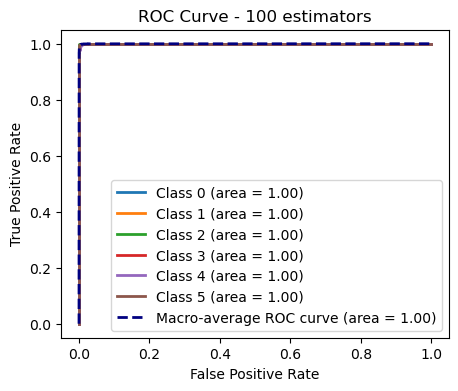

In [19]:
# Plot ROC Curves
plt.figure(figsize=(5, 4))

# Plot ROC curves for each class
for i in range(len(np.unique(y_test_fold))):
    plt.plot(roc_curve_data[0][0][i], roc_curve_data[0][1][i], lw=2, label=f'Class {i} (area = {roc_curve_data[0][2][i]:.2f})')

# Plot the macro-average ROC curve
plt.plot(roc_curve_data[0][0]["macro"], roc_curve_data[0][1]["macro"], color='navy', lw=2, linestyle='--', label=f'Macro-average ROC curve (area = {roc_curve_data[0][2]["macro"]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC Curve - {NUM_BOOST_ROUND} estimators")
plt.legend(loc='lower right')
plt.savefig(f"results/mafaulda_main_classes_rounds={NUM_BOOST_ROUND}_maxdepth={params['max_depth']}_roc-curve.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")
plt.show()


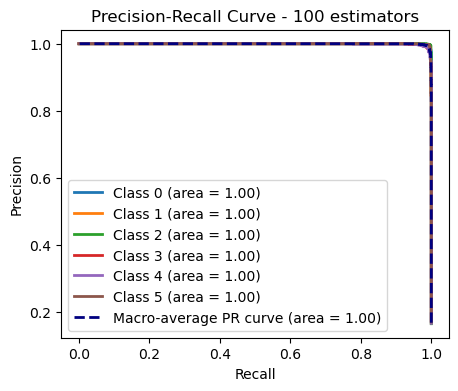

In [20]:
# Plot Precision-Recall Curves
plt.figure(figsize=(5, 4))

# Iterate over each class to plot the PR curve
for i in range(len(np.unique(y_test_fold))):
    plt.plot(pr_curve_data[0][1][i], pr_curve_data[0][0][i], lw=2, label=f'Class {i} (area = {pr_curve_data[0][2][i]:.2f})')

# Plot the macro-average PR curve
plt.plot(pr_curve_data[0][1]["macro"], pr_curve_data[0][0]["macro"], color='navy', lw=2, linestyle='--', label=f'Macro-average PR curve (area = {pr_curve_data[0][2]["macro"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f"Precision-Recall Curve - {NUM_BOOST_ROUND} estimators")
plt.legend(loc='lower left')
plt.savefig(f"results/mafaulda_main_classes_rounds={NUM_BOOST_ROUND}_maxdepth={params['max_depth']}_pr-curve.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

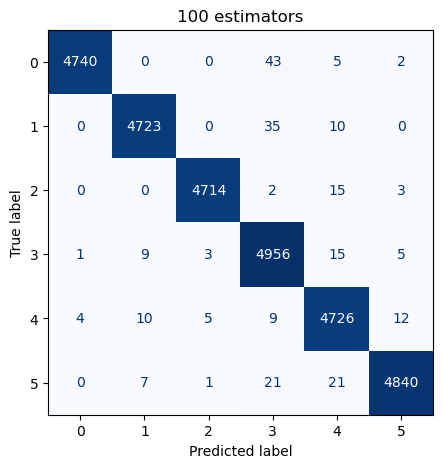

In [21]:
# Ploting Confusion Matrix
cm = metrics.confusion_matrix(y_test_all, y_pred_all)
# class_names = list(df_resampled["label"].unique())
class_names = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5"
]
fig, ax = plt.subplots(figsize=(5, 5))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
ax.set_title(f"{NUM_BOOST_ROUND} estimators")
# plt.xticks(rotation=45, ha='right')
plt.savefig(f"results/mafaulda_main_classes_rounds={NUM_BOOST_ROUND}_maxdepth={params['max_depth']}_confusion-matrix.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

Plotting the feature importance.

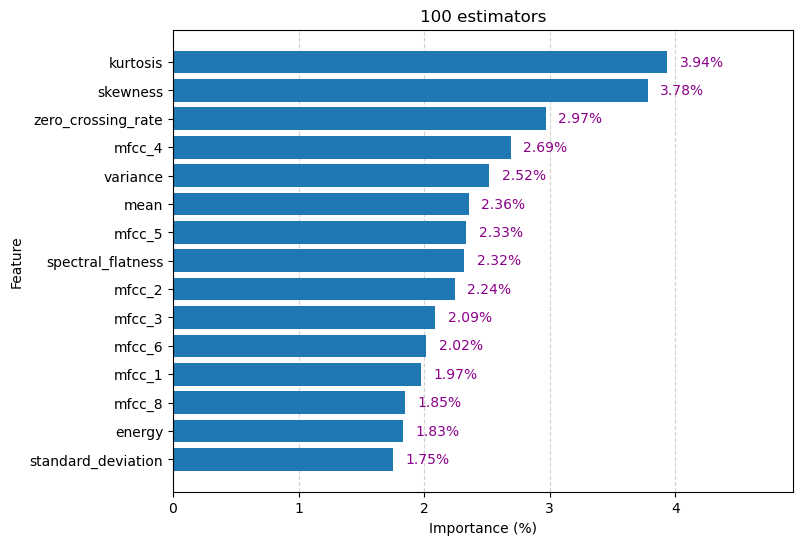

In [22]:
# Get feature names
feature_names = df.columns.drop(['class', 'label', 'filename', 'source'])

# Get the feature importances from the last trained model
feature_importances = bst.get_score(importance_type='weight')

# Map the feature importances to the original feature names
importance_df = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
importance_df.index = [feature_names[int(feat[1:])] for feat in importance_df.index]  # Convert 'f0', 'f1', ... to feature names
importance_df.index.name = 'feature'
importance_df.reset_index(inplace=True)

# Normalize importances to sum up to 1 and convert to percentage
importance_df['importance'] /= importance_df['importance'].sum()
importance_df['importance_percent'] = importance_df['importance'] * 100

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Select the top 15 features
top_features = importance_df.head(15)

# Plot the feature importances as percentages
plt.figure(figsize=(8, 6))
bars = plt.barh(top_features['feature'], top_features['importance_percent'], zorder=2)
plt.grid(linestyle='--', axis='x', linewidth=0.85, color='gray', alpha=0.35, zorder=0)
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top

# Add the importance values to the right of each bar
for bar, value in zip(bars, top_features['importance_percent']):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{value:.2f}%', va='center', color='darkmagenta')

# Set the xlim to ensure the text stays within the plot
plt.xlim(0, top_features['importance_percent'].max() + 1)  # Add minimal padding to the xlim

plt.title(f"{NUM_BOOST_ROUND} estimators")

plt.savefig(f"results/mafaulda_main_classes_rounds={NUM_BOOST_ROUND}_maxdepth={params['max_depth']}_feature-importance.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

In [23]:
def train_model(X_train, y_train, n_estimators=10, verbose_eval=False):
    skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # define parameters for the XGBoost model
    params = {
        'max_depth':                5,
        'learning_rate':            0.1,
        'subsample':                0.7,
        'colsample_bytree':         0.8,
        'colsample_bylevel':        0.8,
        'objective':                'multi:softprob',
        'eval_metric':              'mlogloss',
        'random_state':             42,
        'tree_method':              'hist',
        'device':                   'cuda',
        'num_class':                len(np.unique(y_train))
    }

    # Lists to store accuracy of each fold and predictions
    accuracy_list   = []
    precision_list  = []
    recall_list     = []
    f1_list         = []
    fbeta_list      = []
    rocauc_list     = []
    pr_auc_list     = []
    roc_curve_data  = []
    pr_curve_data   = []

    y_test_all = []
    y_pred_all = []

    # Perform Stratified K-Fold Cross Validation
    fold_number = 1
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        
        # Convert the datasets into DMatrix
        dtrain = DMatrix(X_train_fold, label=y_train_fold)
        dtest = DMatrix(X_test_fold, label=y_test_fold)
        
        # Train the model
        evals = [(dtest, 'eval'), (dtrain, 'train')]
        bst = train(params, dtrain, num_boost_round=n_estimators, evals=evals, verbose_eval=False)
        
        # Make predictions
        y_pred_proba = bst.predict(dtest)
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(np.unique(y_test_fold))):
            fpr[i], tpr[i], _ = metrics.roc_curve(y_test_fold == i, y_pred_proba[:, i])
            roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        
        # Compute macro-average ROC curve and ROC area
        fpr["macro"], tpr["macro"], _ = metrics.roc_curve(
            np.ravel(y_test_fold[:, np.newaxis] == np.arange(len(np.unique(y_test_fold))), order='C'),
            np.ravel(y_pred_proba)
        )
        roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

        # Store ROC Curve Data
        roc_curve_data.append((fpr, tpr, roc_auc))
        
        # Compute Precision-Recall curve and PR area for each class
        precision = dict()
        recall = dict()
        pr_auc = dict()
        for i in range(len(np.unique(y_test_fold))):
            precision[i], recall[i], _ = metrics.precision_recall_curve(y_test_fold == i, y_pred_proba[:, i])
            pr_auc[i] = metrics.auc(recall[i], precision[i])
        
        # Compute Precision-Recall curve and PR AUC for each class
        precision = dict()
        recall = dict()
        pr_auc = dict()
        for i in range(len(np.unique(y_test_fold))):
            precision[i], recall[i], _ = metrics.precision_recall_curve(y_test_fold == i, y_pred_proba[:, i])
            pr_auc[i] = metrics.auc(recall[i], precision[i])
        
        # Compute macro-average Precision-Recall curve and PR AUC
        precision["macro"], recall["macro"], _ = metrics.precision_recall_curve(
            np.ravel(y_test_fold[:, np.newaxis] == np.arange(len(np.unique(y_test_fold))), order='C'),
            np.ravel(y_pred_proba)
        )
        pr_auc["macro"] = metrics.auc(recall["macro"], precision["macro"])

        # Store PR Curve Data
        pr_curve_data.append((precision, recall, pr_auc))

        # Calculate metrics (accuracy, precision, recall, f1-score, fbeta, and AUC)
        MULTICLASS_AVERAGE = "macro"
        accuracy    = metrics.accuracy_score(y_test_fold, y_pred)
        precision   = metrics.precision_score(y_test_fold, y_pred, average=MULTICLASS_AVERAGE)
        recall      = metrics.recall_score(y_test_fold, y_pred, average=MULTICLASS_AVERAGE)
        f1          = metrics.f1_score(y_test_fold, y_pred, average=MULTICLASS_AVERAGE)
        fbeta       = metrics.fbeta_score(y_test_fold, y_pred, beta=2.0, average=MULTICLASS_AVERAGE)
        rocauc      = metrics.roc_auc_score(y_test_fold, y_pred_proba, average=MULTICLASS_AVERAGE, multi_class="ovr")
        auc         = roc_auc["macro"]

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        fbeta_list.append(fbeta)
        rocauc_list.append(rocauc)
        pr_auc_list.append(pr_auc["macro"])

        # Store predictions for confusion matrix
        y_test_all.extend(y_test_fold)
        y_pred_all.extend(y_pred)
        
        print(f'Fold {fold_number} --> accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, f1: {f1:.4f}, fbeta: {fbeta:.4f}, ROC-AUC: {rocauc:.4f}, AUC: {auc:.4f}')
        
        fold_number += 1


    # # Calculate the mean accuracy
    # mean_accuracy   = np.mean(accuracy_list)
    # mean_precision  = np.mean(precision_list)
    # mean_recall     = np.mean(recall_list)
    # mean_f1         = np.mean(f1_list)
    # mean_fbeta      = np.mean(fbeta_list)
    # mean_rocauc     = np.mean(rocauc_list)
    # mean_pr_auc     = np.mean(pr_auc_list)

    # print()
    # print(f"Mean accuracy:              {mean_accuracy:.4f} ± {np.std(accuracy_list):.4f}")
    # print(f"Mean precision:             {mean_precision:.4f} ± {np.std(precision_list):.4f}")
    # print(f"Mean recall:                {mean_recall:.4f} ± {np.std(recall_list):.4f}")
    # print(f"Mean F1-Score:              {mean_f1:.4f} ± {np.std(f1_list):.4f}")
    # print(f"Mean FBeta-Score:           {mean_fbeta:.4f} ± {np.std(fbeta_list):.4f}")
    # print(f"Mean ROC-AUC:               {mean_rocauc:.4f} ± {np.std(rocauc_list):.4f}")
    # print(f"Mean Precision-Recall AUC:  {mean_pr_auc:.4f} ± {np.std(pr_auc_list):.4f}")
    # print()
    
    return accuracy_list, precision_list, recall_list, f1_list, fbeta_list, rocauc_list, pr_auc_list, y_test_all, y_pred_all

In [24]:
# Train model with different numbers of estimators
full_accuracy_list  = []
full_precision_list = []
full_recall_list    = []
full_f1_list        = []
full_fbeta_list     = []
full_roc_auc_list   = []
full_pr_auc_list    = []
full_y_test_all     = []
full_y_pred_all     = []

INITIAL_VALUE   = 25
FINAL_VALUE     = 300
STEP_VALUE      = 25

for n_estimators in range(INITIAL_VALUE, FINAL_VALUE + STEP_VALUE, STEP_VALUE):
    print()
    print(f"Number of estimators: {n_estimators:3} ...")
    accuracy_list, precision_list, recall_list, f1_list, fbeta_list, roc_auc_list, pr_auc_list, y_test_all, y_pred_all = train_model(X_train, y_train, n_estimators, verbose_eval=True)
    
    full_accuracy_list.append(accuracy_list)
    full_precision_list.append(precision_list)
    full_recall_list.append(recall_list)
    full_f1_list.append(f1_list)
    full_fbeta_list.append(fbeta_list)
    full_roc_auc_list.append(roc_auc_list)
    full_pr_auc_list.append(pr_auc_list)
    full_y_test_all.extend(y_test_all)
    full_y_pred_all.extend(y_pred_all)

full_mean_accuracy  = np.mean(full_accuracy_list, axis=1)
full_std_accuracy   = np.std(full_accuracy_list, axis=1)

full_mean_precision = np.mean(full_precision_list, axis=1)
full_std_precision  = np.std(full_precision_list, axis=1)

full_mean_recall    = np.mean(full_recall_list, axis=1)
full_std_recall     = np.std(full_recall_list, axis=1)

full_mean_f1        = np.mean(full_f1_list, axis=1)
full_std_f1         = np.std(full_f1_list, axis=1)

full_mean_fbeta     = np.mean(full_fbeta_list, axis=1)
full_std_fbeta      = np.std(full_fbeta_list, axis=1)

full_mean_roc_auc    = np.mean(full_roc_auc_list, axis=1)
full_std_roc_auc     = np.std(full_roc_auc_list, axis=1)

full_mean_pr_auc    = np.mean(full_pr_auc_list, axis=1)
full_std_pr_auc     = np.std(full_pr_auc_list, axis=1)


Number of estimators:  25 ...
Fold 1 --> accuracy: 0.9418, precision: 0.9436, recall: 0.9419, f1: 0.9424, fbeta: 0.9420, ROC-AUC: 0.9972, AUC: 0.9972
Fold 2 --> accuracy: 0.9528, precision: 0.9546, recall: 0.9529, f1: 0.9534, fbeta: 0.9530, ROC-AUC: 0.9975, AUC: 0.9978
Fold 3 --> accuracy: 0.9530, precision: 0.9546, recall: 0.9530, f1: 0.9535, fbeta: 0.9531, ROC-AUC: 0.9976, AUC: 0.9980
Fold 4 --> accuracy: 0.9521, precision: 0.9535, recall: 0.9522, f1: 0.9526, fbeta: 0.9523, ROC-AUC: 0.9974, AUC: 0.9976
Fold 5 --> accuracy: 0.9497, precision: 0.9507, recall: 0.9498, f1: 0.9501, fbeta: 0.9499, ROC-AUC: 0.9974, AUC: 0.9977

Number of estimators:  50 ...
Fold 1 --> accuracy: 0.9698, precision: 0.9706, recall: 0.9698, f1: 0.9700, fbeta: 0.9698, ROC-AUC: 0.9992, AUC: 0.9992
Fold 2 --> accuracy: 0.9760, precision: 0.9767, recall: 0.9761, f1: 0.9763, fbeta: 0.9761, ROC-AUC: 0.9993, AUC: 0.9994
Fold 3 --> accuracy: 0.9746, precision: 0.9751, recall: 0.9746, f1: 0.9748, fbeta: 0.9747, ROC-AUC

In [26]:
for i in range(full_mean_accuracy.shape[0]):
    estimators = list(range(25, 300+25, 25))
    print(f"----- {estimators[i]} estimators -----")
    print(f"Accuracy:       {full_mean_accuracy[i]:.4f} ± {full_std_accuracy[i]:.4f}")
    print(f"Precision:      {full_mean_precision[i]:.4f} ± {full_std_precision[i]:.4f}")
    print(f"Recall:         {full_mean_recall[i]:.4f} ± {full_std_recall[i]:.4f}")
    print(f"F-1 Score:      {full_mean_f1[i]:.4f} ± {full_std_f1[i]:.4f}")
    print(f"F-Beta Score:   {full_mean_fbeta[i]:.4f} ± {full_std_fbeta[i]:.4f}")
    print(f"ROC-AUC:        {full_mean_roc_auc[i]:.4f} ± {full_std_roc_auc[i]:.4f}")
    print(f"PR-AUC:         {full_mean_pr_auc[i]:.4f} ± {full_std_pr_auc[i]:.4f}")
    print()

# np.save(arr=full_mean_accuracy, file=f"results/mafaulda_main_classes_full_mean_accuracy_max-depth={params['max_depth']}.npy")
# np.save(arr=full_std_accuracy, file=f"results/mafaulda_main_classes_full_std_accuracy_max-depth={params['max_depth']}.npy")

----- 25 estimators -----
Accuracy:       0.9499 ± 0.0042
Precision:      0.9514 ± 0.0042
Recall:         0.9499 ± 0.0042
F-1 Score:      0.9504 ± 0.0042
F-Beta Score:   0.9501 ± 0.0042
ROC-AUC:        0.9974 ± 0.0001
PR-AUC:         0.9900 ± 0.0009

----- 50 estimators -----
Accuracy:       0.9736 ± 0.0021
Precision:      0.9743 ± 0.0020
Recall:         0.9736 ± 0.0021
F-1 Score:      0.9738 ± 0.0021
F-Beta Score:   0.9737 ± 0.0021
ROC-AUC:        0.9993 ± 0.0001
PR-AUC:         0.9969 ± 0.0004

----- 75 estimators -----
Accuracy:       0.9854 ± 0.0012
Precision:      0.9857 ± 0.0012
Recall:         0.9854 ± 0.0012
F-1 Score:      0.9855 ± 0.0012
F-Beta Score:   0.9855 ± 0.0012
ROC-AUC:        0.9998 ± 0.0000
PR-AUC:         0.9990 ± 0.0001

----- 100 estimators -----
Accuracy:       0.9918 ± 0.0004
Precision:      0.9919 ± 0.0004
Recall:         0.9918 ± 0.0004
F-1 Score:      0.9918 ± 0.0004
F-Beta Score:   0.9918 ± 0.0004
ROC-AUC:        0.9999 ± 0.0000
PR-AUC:         0.9996 ± 0.0

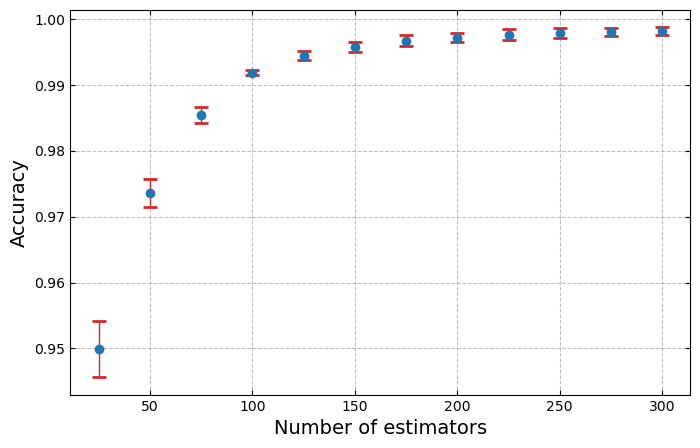

In [27]:
# full_mean_acc = np.load("results/mafaulda_main_classes_full_mean_acc_max-depth=5.npy")
# full_std_acc = np.load("results/mafaulda_main_classes_full_std_acc_max-depth=5.npy")

fig, ax = plt.subplots(figsize=(8, 5))

# INITIAL_VALUE   = 50
# FINAL_VALUE     = 300
# STEP_VALUE      = 50

ax.errorbar(range(INITIAL_VALUE, FINAL_VALUE+STEP_VALUE, STEP_VALUE), full_mean_accuracy, yerr=full_std_accuracy, fmt='o', markersize=6, capsize=5, capthick=2, color="C0", ecolor="C3", elinewidth=1, linestyle='')
ax.grid(True, which='both', linestyle='--', linewidth=0.75, color='gray', alpha=0.5)
ax.xaxis.set_tick_params(direction='in', which='both', top=True, right=True)
ax.yaxis.set_tick_params(direction='in', which='both', right=True)
ax.set_xlabel('Number of estimators', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

plt.savefig(f"results/mafaulda_main_classes_rounds={INITIAL_VALUE}-{FINAL_VALUE}_maxdepth={params['max_depth']}_accuracy_by_number-of-estimators.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

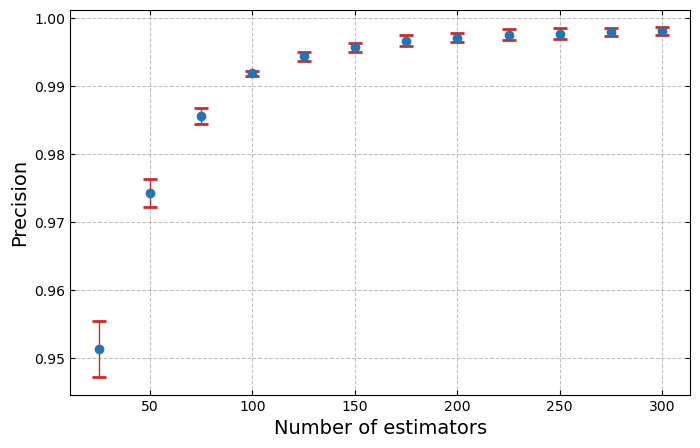

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(range(INITIAL_VALUE, FINAL_VALUE+STEP_VALUE, STEP_VALUE), full_mean_precision, yerr=full_std_precision, fmt='o', markersize=6, capsize=5, capthick=2, color="C0", ecolor="C3", elinewidth=1, linestyle='')
ax.grid(True, which='both', linestyle='--', linewidth=0.75, color='gray', alpha=0.5)
ax.xaxis.set_tick_params(direction='in', which='both', top=True, right=True)
ax.yaxis.set_tick_params(direction='in', which='both', right=True)
ax.set_xlabel('Number of estimators', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)

plt.savefig(f"results/mafaulda_main_classes_rounds={INITIAL_VALUE}-{FINAL_VALUE}_maxdepth={params['max_depth']}_precision_by_number-of-estimators.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

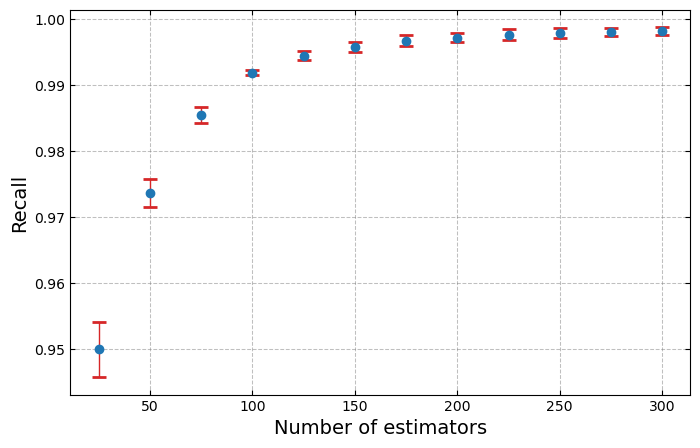

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(range(INITIAL_VALUE, FINAL_VALUE+STEP_VALUE, STEP_VALUE), full_mean_recall, yerr=full_std_recall, fmt='o', markersize=6, capsize=5, capthick=2, color="C0", ecolor="C3", elinewidth=1, linestyle='')
ax.grid(True, which='both', linestyle='--', linewidth=0.75, color='gray', alpha=0.5)
ax.xaxis.set_tick_params(direction='in', which='both', top=True, right=True)
ax.yaxis.set_tick_params(direction='in', which='both', right=True)
ax.set_xlabel('Number of estimators', fontsize=14)
ax.set_ylabel('Recall', fontsize=14)

plt.savefig(f"results/mafaulda_main_classes_rounds={INITIAL_VALUE}-{FINAL_VALUE}_maxdepth={params['max_depth']}_recall_by_number-of-estimators.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

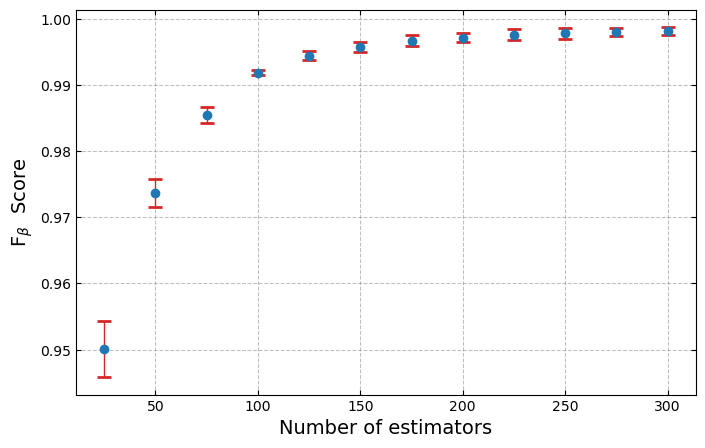

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(range(INITIAL_VALUE, FINAL_VALUE+STEP_VALUE, STEP_VALUE), full_mean_fbeta, yerr=full_std_fbeta, fmt='o', markersize=6, capsize=5, capthick=2, color="C0", ecolor="C3", elinewidth=1, linestyle='')
ax.grid(True, which='both', linestyle='--', linewidth=0.75, color='gray', alpha=0.5)
ax.xaxis.set_tick_params(direction='in', which='both', top=True, right=True)
ax.yaxis.set_tick_params(direction='in', which='both', right=True)
ax.set_xlabel('Number of estimators', fontsize=14)
ax.set_ylabel(r'F$_{\beta}\ $ Score', fontsize=14)

plt.savefig(f"results/mafaulda_main_classes_rounds={INITIAL_VALUE}-{FINAL_VALUE}_maxdepth={params['max_depth']}_fbeta_by_number-of-estimators.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")
plt.show()